In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from dateutil.parser import parse
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.datasets import make_regression
import streamlit as st
from sklearn.neural_network import MLPClassifier
import pickle

#import data
df1 = pd.read_csv("C:/Users/edwin/GitHub/Stock Market Dataset.csv")
df2 = pd.read_csv("C:/Users/edwin/GitHub/nyt-metadata.csv")


C:\Users\edwin\AppData\Local\Temp\ipykernel_10088\1903977901.py:45: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("C:/Users/edwin/GitHub/nyt-metadata.csv")


In [23]:
#PART ONE: Basic Info & Clean Up for Stocks Dataframe
print(df1.head())
print(df1.info())
print(df1.describe())

#Drop unneeded columns
columns_to_drop = ['Natural_Gas_Vol.','Crude_oil_Vol.','Copper_Vol.','Bitcoin_Vol.','Platinum_Vol.','Ethereum_Vol.','Nasdaq_100_Vol.','Apple_Vol.','Tesla_Vol.','Microsoft_Vol.','Silver_Vol.','Google_Vol.','Nvidia_Vol.','Berkshire_Vol.','Netflix_Vol.','Amazon_Vol.','Meta_Vol.','Gold_Vol.']
df1 = df1.drop(columns=columns_to_drop)

# Removing commas from price strings and convert to numeric
price_columns = ['Natural_Gas_Price','Crude_oil_Price','Copper_Price','Bitcoin_Price','Platinum_Price','Ethereum_Price','S&P_500_Price','Nasdaq_100_Price','Apple_Price','Tesla_Price','Microsoft_Price','Silver_Price','Google_Price','Nvidia_Price','Berkshire_Price','Netflix_Price','Amazon_Price','Meta_Price','Gold_Price']
for column in price_columns:
    # Convert to string and replace commas
    df1[column] = df1[column].astype(str).str.replace(',', '')
    # Convert back to numeric
    df1[column] = pd.to_numeric(df1[column], errors='coerce')

#searching for duplicate rows which might throw off my results
print("\nDuplicate rows in df1")
duplicate_rows = df1[df1.duplicated(subset=price_columns, keep=False)]
print(duplicate_rows)

#Reformatting dates and filtering data by date range
df1['Date'] = pd.to_datetime(df1['Date'], dayfirst=True)
df1['Date'] = df1['Date'].dt.normalize()
df1['Date'] = df1['Date'].dt.tz_localize(None)
df1 = df1[(df1['Date'] >= pd.to_datetime('2019-02-03')) & (df1['Date'] <= pd.to_datetime('2023-12-31'))]

print("\n Start & End Dates for Stock Dataframe:")
start_df1 = df1['Date'].min()
end_df1 = df1['Date'].max()
print(start_df1)
print(end_df1)


df1 = df1.sort_values(by='Date')
print(df1.head())
print(df1.info())
print(df1.describe())


 PART ONE: BASIC INFO & CLEAN UP FOR STOCKS DATAFRAME (df1)

Basic details
   Unnamed: 0        Date  Natural_Gas_Price  Natural_Gas_Vol.  \
0           0  02-02-2024              2.079               NaN   
1           1  01-02-2024              2.050          161340.0   
2           2  31-01-2024              2.100          142860.0   
3           3  30-01-2024              2.077          139750.0   
4           4  29-01-2024              2.490            3590.0   

   Crude_oil_Price  Crude_oil_Vol.  Copper_Price  Copper_Vol. Bitcoin_Price  \
0            72.28             NaN        3.8215          NaN     43,194.70   
1            73.82        577940.0        3.8535          NaN     43,081.40   
2            75.85        344490.0        3.9060          NaN     42,580.50   
3            77.82        347240.0        3.9110          NaN     42,946.20   
4            76.78        331930.0        3.8790          NaN     43,299.80   

   Bitcoin_Vol.  ... Berkshire_Price  Berkshire_Vol.

In [24]:
#PART TWO: Basic Info & Clean Up for NYT
print(df2.head())
print(df2.info())
print(df2.describe())

#picking out columns I'll be using
df2 = df2[['pub_date','headline','news_desk']]
#renaming columns for upcoming merge with df1
df2 = df2.rename(columns={'pub_date': 'Date_nyt'})
df2['headline'] = df2['headline'].str.lower()
df2['news_desk'] = df2['news_desk'].str.replace(' ', '_')
df2['news_desk'] = df2['news_desk'].str.lower()

# looking for rows with blank values
#print("\nRows with blank values:")
#print(df2.isnull().sum())
#removing rows where a value is missing
#I know it's not ideal to have blanks, but I don't have a numeric amount to replace a blank text...
df2 = df2.dropna()
#print(df2.isnull().sum())

#There are strings of words where a date should be so I need to search and remove non date values
#function to check if a string is a date
def is_date(string, fuzzy=False):
    try:
        parse(string, fuzzy=fuzzy)
        return True
    except (ValueError, TypeError):
        return False
df2 = df2[df2['Date_nyt'].apply(lambda x: isinstance(x, str) and is_date(x))]
df2['Date_nyt'] = pd.to_datetime(df2['Date_nyt'])
df2['Date_nyt'] = df2['Date_nyt'].dt.normalize()
df2['Date_nyt'] = df2['Date_nyt'].dt.tz_localize(None)

# Remove headlines that fall outside the available dates in df1
df2 = df2[(df2['Date_nyt'] >= '2019-02-03') & (df2['Date_nyt'] <= '2023-12-28')]

#print("\n Updated Start & End Dates for NYT dataset:")
df2 = df2.sort_values(by='Date_nyt')
start_df2 = df2['Date_nyt'].min()
end_df2 = df2['Date_nyt'].max()
#print(start_df2)
#print(end_df2)

print(df2.head())
print(df2.info())
print(df2.describe())

#filter out topics with less influence on stock prices
unique_news_desk_values = df2['news_desk'].dropna().unique()
print("Unique values in 'news_desk':", unique_news_desk_values)
df2 = df2[~df2['news_desk'].isin(['metro', 'letters', 'culture', 'nytnow',
 'sports', 'editorial', 'learning', 'express', 'games', 'arts&leisure', 'summary', 'corrections', 'society', 'dining', 'travel', 'oped', 'obits', 'fashion_&_style', 'tstyle', 'well', 'bookreview', 'newsdesk', 'photo', 'smarter_living', 'styles', 'insider', 'the_learning_network', 'podcasts', 'style', 'weekend', 'magazine', 'opinion', 'gender', 'books', 't_magazine', 'metropolitan', 'briefing', 'arts', 'food', 'specialsections', 'video', 'guides', 'movies', 'times_insider',  'reader_center', 'admin', 'parenting', 'obituaries', 'theater', 'sundayreview', 'nyti', 'health', 'graphics', 'multimedia/photos', 'test', 'en_español', 'watching', 'neediest', 'crosswords_&_games', 'continuousnews', 'live', 'burst', 'athome', 'at_home', 'education', 'sunday_review', 'home_&_garden', 'español', 'digitalnewsdesign', 'special_series', 'interactivenews', 'guide', 'neediest_cases', 'headway', 'homepage', 'slideshows', 'weather', 'projects_and_initiatives',  'local_investigations'])]
unique_news_desk_values = df2['news_desk'].dropna().unique()
print("Unique values in 'news_desk':", unique_news_desk_values)
print(df2.head())
print(df2.info())

#check for duplicate rows
#print("\n Checking for duplicate rows:")
duplicate_rows = df2.duplicated(subset=['Date_nyt', 'headline', 'news_desk'], keep=False)
#print(duplicate_rows)
#no duplicates

#remove stopwords & lemmatizer
#nltk.download('stopwords')
#nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

#Preprocessing text
def preprocess_text(headline):
    headline = ''.join([c for c in headline if c not in ('!', '.', ':', ',', '?', '(', ')', '"')])
    headline = ' '.join([lemmatizer.lemmatize(word) for word in headline.split() if word not in stop_words])
    return headline
df2['headline'] = df2['headline'].apply(preprocess_text)
print(df2.info())
print(df2.describe())

#Building Vader Sentiment score
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
df2['vader_sentiment'] = [sia.polarity_scores(text)['compound'] for text in df2['headline']]

#splitting into test/train datasets
train_df2, test_df2 = train_test_split(df2, test_size=0.2, random_state=42)

# Vectorize headlines
vectorizer = TfidfVectorizer()
train_headline_tfidf = vectorizer.fit_transform(train_df2['headline'])
test_headline_tfidf = vectorizer.transform(test_df2['headline'])

# Use sparse matrices directly
X_train = train_headline_tfidf
X_test = test_headline_tfidf
# Keep 'vader_sentiment' column for training target
y_train = train_df2['vader_sentiment']
y_test = test_df2['vader_sentiment']


 PART TWO: BASIC INFO & CLEAN UP FOR NYT DATASET (df2)

Basic details
                                            abstract  \
0  Article on upcoming New York Giants-Dallas Cow...   
1  Jeanne C Pond letter expresses hope that spiri...   
2  Many experts on Y2K computer problem report th...   
3  WILL the forces of globalism continue to push ...   
4   SPECIAL TODAY  The Millennium  Envisioning th...   

                                             web_url  \
0  https://www.nytimes.com/2000/01/01/sports/pro-...   
1  https://www.nytimes.com/2000/01/01/opinion/l-o...   
2  https://www.nytimes.com/2000/01/01/us/1-1-00-t...   
3  https://www.nytimes.com/2000/01/01/news/vision...   
4  https://www.nytimes.com/2000/01/01/nyregion/in...   

                                             snippet  \
0  Article on upcoming New York Giants-Dallas Cow...   
1  Jeanne C Pond letter expresses hope that spiri...   
2  Many experts on Y2K computer problem report th...   
3                              

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\edwin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Mean Squared Error: 0.08250987026298315
R² Score: 0.5540951697374297
Predicted sentiments: [-0.70186055  0.0224283  -0.15052889 -0.33126493  0.21929284]
Actual sentiments: [-0.7579  0.      0.0772 -0.2732  0.4939]


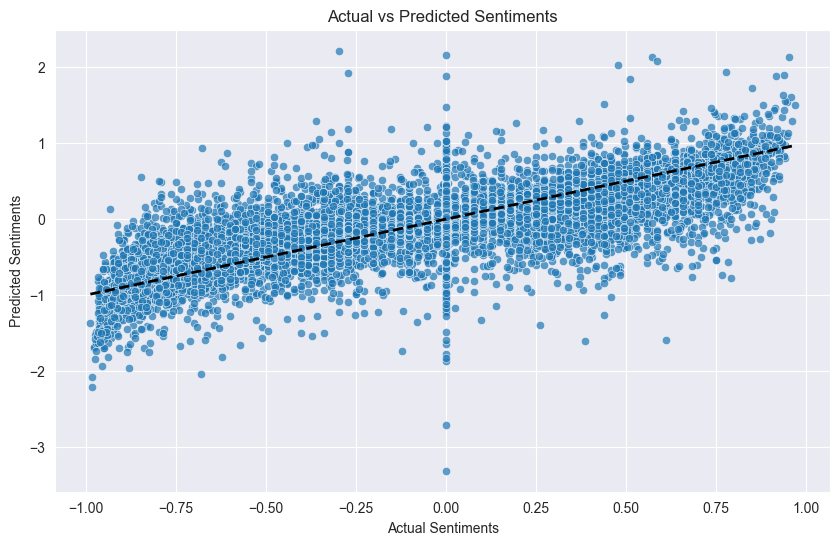

In [29]:
#PART THREE: REGRESSIONS FOR PREDICTING HEADLINE SENTIMENT
#Linear Regression
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Make predictions using the test data
y_pred = linear_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')
print("Predicted sentiments:", y_pred[:5])
print("Actual sentiments:", y_test[:5].values)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Sentiments')
plt.ylabel('Predicted Sentiments')
plt.title('Actual vs Predicted Sentiments')
plt.show()

#Mean Squared Error: 0.08250987026298315
#R² Score: 0.5540951697374297

In [26]:
#Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    max_depth=100
)
rf_regressor.fit(train_headline_tfidf, y_train)
y_pred = rf_regressor.predict(test_headline_tfidf)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Random Forest Mean Squared Error: {mse}')
print(f'Random Forest R² Score: {r2}')

##Attempting Neural Network
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the neural network
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=1000, random_state=42)

# Train the network
mlp.fit(X_train, y_train)

# Make predictions
y_pred = mlp.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

#Random Forest Mean Squared Error: 0.09994295683716668
#Random Forest R² Score: 0.4598822290912066

Random Forest Mean Squared Error: 0.09994295683716668
Random Forest R² Score: 0.4598822290912066


In [27]:
#Gradient Boosting
gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=30, random_state=42)
gbm.fit(train_headline_tfidf, y_train)
y_pred = gbm.predict(test_headline_tfidf)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Gradient Boosting Mean Squared Error: {mse}')
print(f'Gradient Boosting R² Score: {r2}')

#Gradient Boosting Mean Squared Error: 0.07600352134728999
#Gradient Boosting R² Score: 0.58925717398776

Gradient Boosting Mean Squared Error: 0.07600352134728999
Gradient Boosting R² Score: 0.58925717398776


In [58]:
import joblib

joblib.dump(linear_regressor, 'linear_regressor.joblib')
joblib.dump(vectorizer, 'vectorizer.joblib')



['vectorizer.joblib']

In [31]:
# PART FOUR: Merge Stock and NYT data
#making a new data frame, only rows where `Date` in `df1` and `Date_nyt` in `df2` have the same value
df = pd.merge(df1, df2, left_on='Date', right_on='Date_nyt', how='inner')
df = df.sort_values('Date')
aggregated_df = df.groupby('Date').agg({
    'vader_sentiment': 'mean',
    'Natural_Gas_Price': 'first',
    'Crude_oil_Price': 'first',
    'Copper_Price': 'first',
    'Bitcoin_Price': 'first',
    'Platinum_Price': 'first',
    'Ethereum_Price': 'first',
    'S&P_500_Price': 'first',
    'Nasdaq_100_Price': 'first',
    'Apple_Price': 'first',
    'Tesla_Price': 'first',
    'Microsoft_Price': 'first',
    'Silver_Price': 'first',
    'Google_Price': 'first',
    'Nvidia_Price': 'first',
    'Berkshire_Price': 'first',
    'Netflix_Price': 'first',
    'Amazon_Price': 'first',
    'Meta_Price': 'first',
    'Gold_Price': 'first'
}).reset_index()

#creating some new variables related to price
for column_name in price_columns:
    # Define the new column names with f-strings
    price_diff_column = f'{column_name}_Difference'
    percent_change_column = f'{column_name}_Percent_Change'
    indicator_column = f'{column_name}_Change_Indicator'
    # Calculate difference from the previous day's value for the current column
    aggregated_df[price_diff_column] = aggregated_df[column_name].diff()
    # Calculate percentage change for the current column
    aggregated_df[percent_change_column] = aggregated_df[column_name].pct_change() * 100
    # Create a 0/1 indicator for positive/negative percentage change
    aggregated_df[indicator_column] = np.where(aggregated_df[percent_change_column] > 0, 1, 0)

#creating lagged sentiment scores
aggregated_df = aggregated_df.sort_values('Date')
aggregated_df['lagged_sentiment_1d'] = aggregated_df['vader_sentiment'].shift(1)
aggregated_df['lagged_sentiment_2d'] = aggregated_df['vader_sentiment'].shift(2)
aggregated_df['lagged_sentiment_7d'] = aggregated_df['vader_sentiment'].shift(7)

# Display the result
print(aggregated_df.head())


        Date  vader_sentiment  Natural_Gas_Price  Crude_oil_Price  \
0 2019-02-04        -0.148018              2.660            54.56   
1 2019-02-05        -0.072854              2.662            53.66   
2 2019-02-06        -0.095477              2.662            54.01   
3 2019-02-07        -0.150134              2.551            52.64   
4 2019-02-08        -0.078194              2.583            52.72   

   Copper_Price  Bitcoin_Price  Platinum_Price  Ethereum_Price  S&P_500_Price  \
0        2.7975         3462.8          822.50          107.90        2724.87   
1        2.8205         3468.4          821.35          107.37        2737.70   
2        2.8400         3404.3          807.10          104.63        2731.61   
3        2.8320         3397.7          800.80          104.55        2706.05   
4        2.8140         3661.7          802.20          119.23        2707.88   

   Nasdaq_100_Price  ...  Amazon_Price_Change_Indicator  \
0           6959.96  ...               

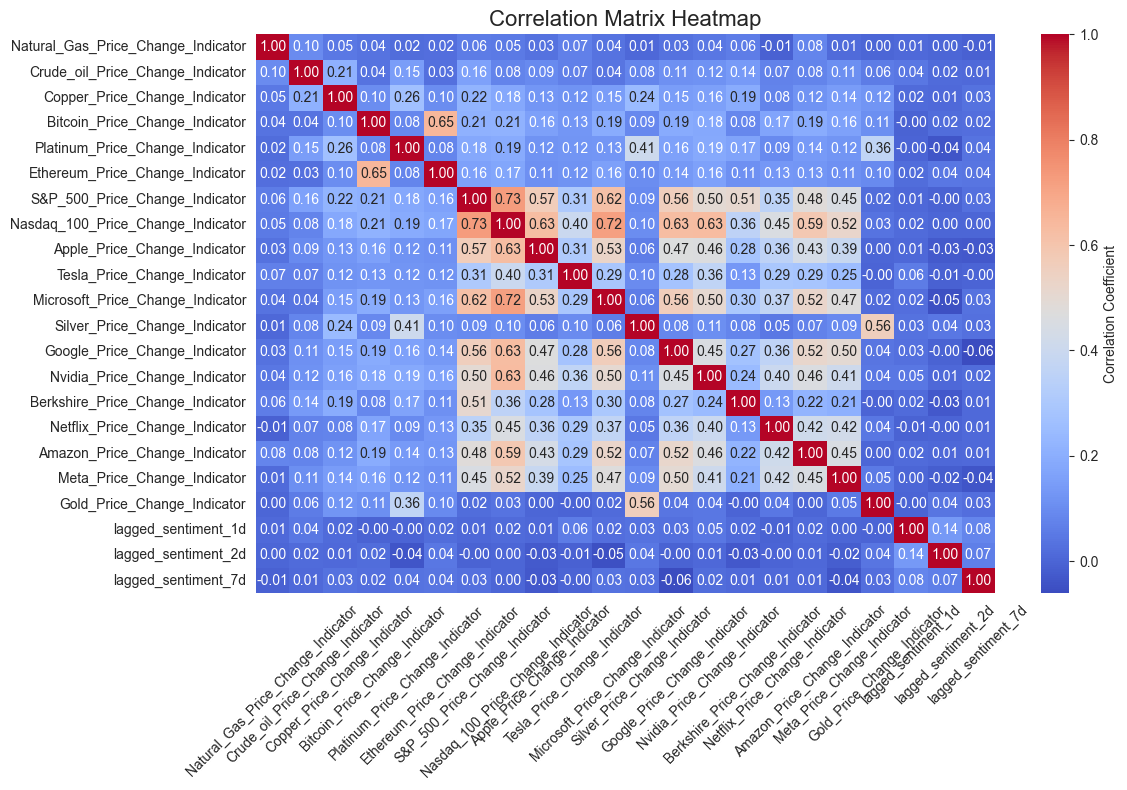

                                    Natural_Gas_Price_Change_Indicator  \
Natural_Gas_Price_Change_Indicator                            1.000000   
Crude_oil_Price_Change_Indicator                              0.097474   
Copper_Price_Change_Indicator                                 0.049535   
Bitcoin_Price_Change_Indicator                                0.036655   
Platinum_Price_Change_Indicator                               0.018330   
Ethereum_Price_Change_Indicator                               0.021899   
S&P_500_Price_Change_Indicator                                0.058719   
Nasdaq_100_Price_Change_Indicator                             0.051395   
Apple_Price_Change_Indicator                                  0.031084   
Tesla_Price_Change_Indicator                                  0.069763   
Microsoft_Price_Change_Indicator                              0.036607   
Silver_Price_Change_Indicator                                 0.009044   
Google_Price_Change_Indicator         

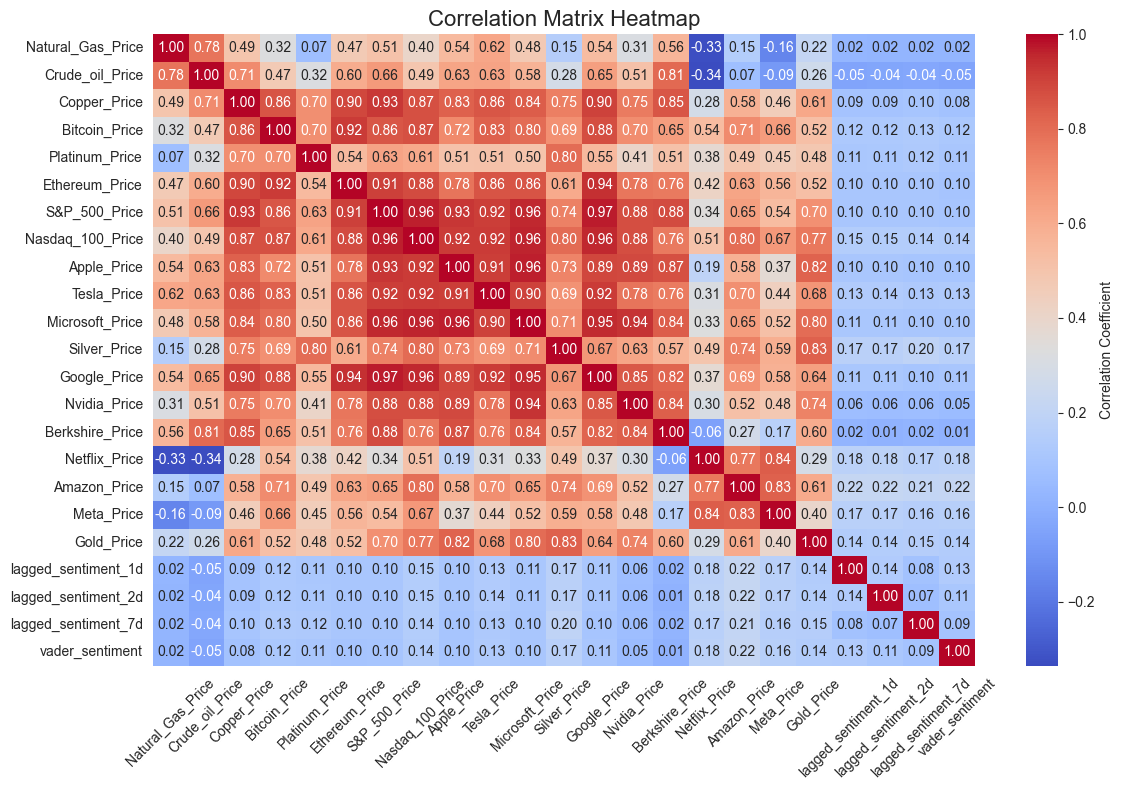

                     Natural_Gas_Price  Crude_oil_Price  Copper_Price  \
Natural_Gas_Price             1.000000         0.778185      0.494703   
Crude_oil_Price               0.778185         1.000000      0.712359   
Copper_Price                  0.494703         0.712359      1.000000   
Bitcoin_Price                 0.321263         0.471996      0.859197   
Platinum_Price                0.065746         0.320731      0.699097   
Ethereum_Price                0.468544         0.600888      0.895500   
S&P_500_Price                 0.508817         0.661131      0.926698   
Nasdaq_100_Price              0.403236         0.491699      0.871877   
Apple_Price                   0.544081         0.625387      0.831904   
Tesla_Price                   0.620870         0.632218      0.856657   
Microsoft_Price               0.476720         0.576885      0.840150   
Silver_Price                  0.152721         0.282701      0.748232   
Google_Price                  0.536947         0.64

In [38]:
#Examining possible relationship between headline sentiment & stock prices to find biggest relationship
correlation_columns = ['Natural_Gas_Price_Change_Indicator','Crude_oil_Price_Change_Indicator','Copper_Price_Change_Indicator','Bitcoin_Price_Change_Indicator','Platinum_Price_Change_Indicator','Ethereum_Price_Change_Indicator','S&P_500_Price_Change_Indicator','Nasdaq_100_Price_Change_Indicator','Apple_Price_Change_Indicator','Tesla_Price_Change_Indicator','Microsoft_Price_Change_Indicator','Silver_Price_Change_Indicator','Google_Price_Change_Indicator','Nvidia_Price_Change_Indicator','Berkshire_Price_Change_Indicator',
'Netflix_Price_Change_Indicator','Amazon_Price_Change_Indicator','Meta_Price_Change_Indicator','Gold_Price_Change_Indicator','lagged_sentiment_1d','lagged_sentiment_2d','lagged_sentiment_7d']
filtered_df = aggregated_df[correlation_columns]
correlation_matrix = correlation_matrix = filtered_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
print(correlation_matrix)

correlation_columns = [                       'Natural_Gas_Price', 'Crude_oil_Price', 'Copper_Price', 'Bitcoin_Price', 'Platinum_Price', 'Ethereum_Price', 'S&P_500_Price', 'Nasdaq_100_Price', 'Apple_Price', 'Tesla_Price', 'Microsoft_Price', 'Silver_Price', 'Google_Price', 'Nvidia_Price', 'Berkshire_Price',
                        'Netflix_Price', 'Amazon_Price', 'Meta_Price', 'Gold_Price','lagged_sentiment_1d','lagged_sentiment_2d','lagged_sentiment_7d','vader_sentiment']

filtered_df = aggregated_df[correlation_columns]
correlation_matrix = correlation_matrix = filtered_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
print(correlation_matrix)

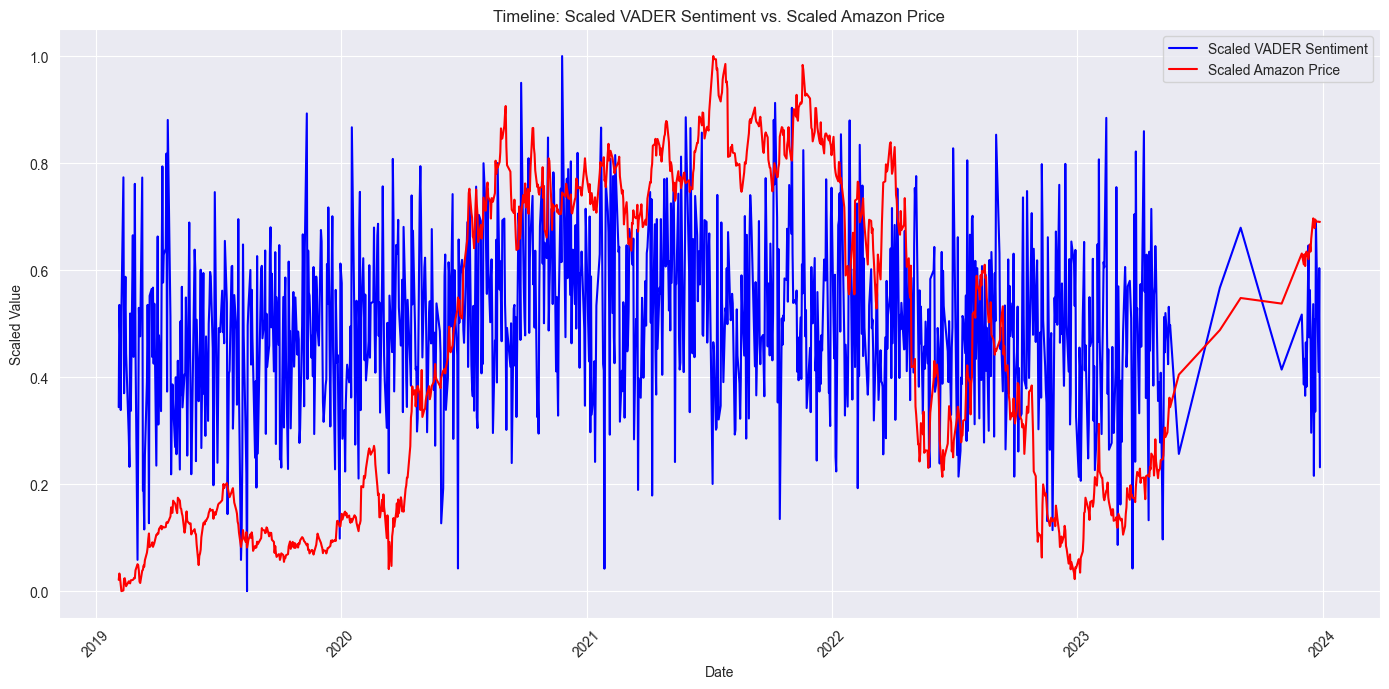

In [47]:
#Timeline of Amazon Price versus Vader Sentiment Score
# Normalize (scale) the data for comparison
aggregated_df['scaled_vader_sentiment'] = (
                                                  aggregated_df['vader_sentiment'] - aggregated_df[
                                              'vader_sentiment'].min()
                                          ) / (aggregated_df['vader_sentiment'].max() - aggregated_df[
    'vader_sentiment'].min())

aggregated_df['scaled_amazon_price'] = (
                                               aggregated_df['Amazon_Price'] - aggregated_df['Amazon_Price'].min()
                                       ) / (aggregated_df['Amazon_Price'].max() - aggregated_df['Amazon_Price'].min())


plt.figure(figsize=(14, 7))
plt.plot(aggregated_df['Date'], aggregated_df['scaled_vader_sentiment'], label='Scaled VADER Sentiment', color='blue')
plt.plot(aggregated_df['Date'], aggregated_df['scaled_amazon_price'], label='Scaled Amazon Price', color='red')
plt.title('Timeline: Scaled VADER Sentiment vs. Scaled Amazon Price')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [56]:
train_aggregated_df, test_aggregated_df = train_test_split(aggregated_df, test_size=0.2, random_state=42)